In [83]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import pymorphy2

In [10]:
from params import EXPERIMENT_RAW_DATA_PATH, EXPERIMENT_PROCESSED_DATA_FOLDER, TEST_SET_FILENAME, TRAIN_SET_FILENAME, RANDOM_SEED
np.random.seed(RANDOM_SEED)

In [3]:
df = pd.read_excel(EXPERIMENT_RAW_DATA_PATH)

In [4]:
df.head()

,Unnamed: 0,post_type,author,published,bank,title,body,rating
0,0,Review,ned.veegres,2021-03-07,Тинькофф Банк,Акция Тинькофф &quot;приведи друга&quot;,Привёл друга по акции за вознаграждение 500 ру...,1
1,1,Review,user_1043441,2021-03-07,МТС Банк,Блокировка карты из-за сомнительных операций,"Началось все с того, что без предупреждения и ...",2
2,2,Review,gneg,2021-03-05,Тинькофф Банк,Очень небезопасно доверять им свои деньги,Оставил заявку на дебетовую карту. Со второй п...,1
3,3,Review,sashakrs73@gmail.com,2021-03-05,Тинькофф Банк,3-й раз не привозят карту!,Заявка на карту была сделана 21 февраля. Доста...,1
4,4,Review,89776164857,2021-03-05,СберБанк,Не зачислили деньги,НЕ ЗАЧИСЛИЛИ ДЕНЬГИ!!!!!!!!!! &amp;amp;nbsp; Б...,1


In [5]:
df.shape

(56125, 8)

# SPLIT AT TRAIN AND TEST

In [11]:
def split_data(df: pd.DataFrame, frac: float=0.75) -> tuple:
    to_train = int(df.shape[0] * frac)
    unique_users = df.author.drop_duplicates().values
    train_users = set(np.random.choice(unique_users, size=to_train, replace=False))
    train_set = df[df.author.isin(train_users)].copy()
    test_set = df[~df.author.isin(train_users)].copy()
    return train_set, test_set


In [18]:
train, test = split_data(df)

In [19]:
train

,Unnamed: 0,post_type,author,published,bank,title,body,rating
0,0,Review,ned.veegres,2021-03-07,Тинькофф Банк,Акция Тинькофф &quot;приведи друга&quot;,Привёл друга по акции за вознаграждение 500 ру...,1
1,1,Review,user_1043441,2021-03-07,МТС Банк,Блокировка карты из-за сомнительных операций,"Началось все с того, что без предупреждения и ...",2
2,2,Review,gneg,2021-03-05,Тинькофф Банк,Очень небезопасно доверять им свои деньги,Оставил заявку на дебетовую карту. Со второй п...,1
3,3,Review,sashakrs73@gmail.com,2021-03-05,Тинькофф Банк,3-й раз не привозят карту!,Заявка на карту была сделана 21 февраля. Доста...,1
4,4,Review,89776164857,2021-03-05,СберБанк,Не зачислили деньги,НЕ ЗАЧИСЛИЛИ ДЕНЬГИ!!!!!!!!!! &amp;amp;nbsp; Б...,1
...,...,...,...,...,...,...,...,...
56118,18,Review,Giperion2000,2012-12-28,Связной Банк,Это позор!,"Извините, дальше пойдёт просто крик души! ЭТО ...",1
56119,19,Review,user79175,2012-11-28,Хоум Кредит Банк,Home credit опять выходит на связь,Дважды на данном ресурсе я просил данную орган...,1
56121,21,Review,Giperion2000,2012-08-29,СберБанк,"Карта, которая никогда меня не покинет!","Скажу честно, не было желания писать отзыв, та...",2
56123,23,Review,tjuna,2011-06-16,Альфа-Банк,Банкомат выдал меньшую сумму,Здравствуйте.&amp;lt;br&amp;gt;12 июня 2011г м...,1


<AxesSubplot:>

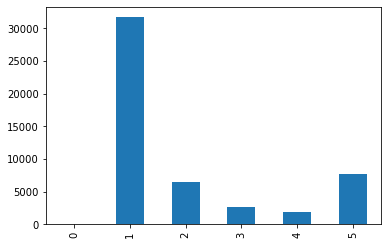

In [20]:
train.rating.value_counts().sort_index().plot.bar()

In [21]:
train.rating.value_counts().sort_index()

0        3
1    31693
2     6528
3     2629
4     1889
5     7659
Name: rating, dtype: int64

<AxesSubplot:title={'center':'Title Length'}, ylabel='Frequency'>

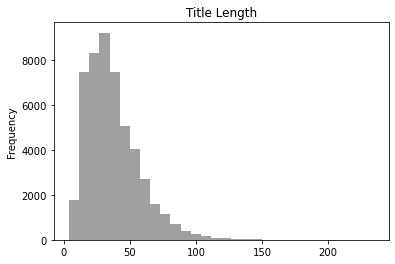

In [32]:
train.title.str.len().plot.hist(bins=30, alpha=0.75, color='grey', title="Title Length")

<AxesSubplot:xlabel='rating', ylabel='title_len'>

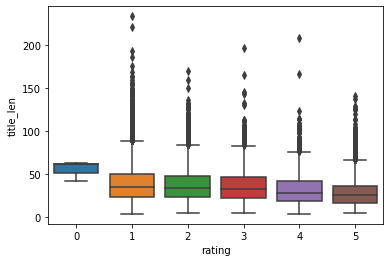

In [40]:
sns.boxplot(y='title_len',x='rating',data=train.assign(title_len=train.title.str.len()))

<AxesSubplot:xlabel='rating', ylabel='review_len'>

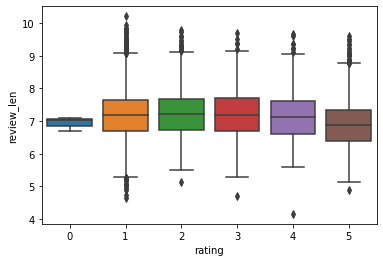

In [43]:
sns.boxplot(y='review_len',x='rating',data=train.assign(review_len=train.body.str.len().map(np.log)))

In [95]:


def apply_func_to_cols(df: pd.DataFrame, columns: list, suffix: str, func) -> pd.DataFrame:
    tmp = df.copy()
    
    for colname in columns:
        tmp[colname+suffix] = tmp[colname].map(func)
    
    return tmp

def add_len(df: pd.DataFrame, text_columns: list) -> pd.DataFrame:
    return apply_func_to_cols(df,text_columns,'_len',len)

def count_pattern_share(pattern: str, text: str):
    if  text is np.nan or text is None:
        return None
    if not text:
        return 0
    caps = re.findall(pattern, text)
    len_caps = len(''.join(caps))
    return len_caps / len(text)

def count_caps_share(text: str) -> float:
    return count_pattern_share('[А-Я]', text)

def count_stress_share(text: str) -> float:
    return count_pattern_share('\!', text)

def count_quest_share(text: str) -> float:
    return count_pattern_share('\?', text)

def add_share_caps(df: pd.DataFrame, text_columns: list) -> pd.DataFrame:
    return apply_func_to_cols(df, text_columns, '_caps_share', count_caps_share)

def add_share_stress(df: pd.DataFrame, text_columns: list) -> pd.DataFrame:
    return apply_func_to_cols(df, text_columns, '_caps_share', count_stress_share)

def add_share_quest(df: pd.DataFrame, text_columns: list) -> pd.DataFrame:
    return apply_func_to_cols(df, text_columns, '_quest_share', count_quest_share)

def replace_digits(text:str):
    return re.sub('\d+','somedigits',text)

def replace_variants(text, variants, replace_values):
    if len(variants) != len(replace_values):
        raise Exception("varirants and replace_values must have the same length")
    if not isinstance(variants,list):
        raise Exception("varirants maust be a list")
    if not isinstance(replace_values,list):
        raise Exception("replace_values maust be a list")

    res = text
    for v, r in zip(variants, replace_values):
        res = res.replace(v,r)
    return res

def replace_months(text: str):
    months = ['январь','февраль','март','апрель','май','июнь','июль','август','сентябрь','октябрь','ноябрь','декабрь']
    return replace_variants(text, months,['somemonth']*12)

def standartize_text(text: str, analyzer: pymorphy2.MorphAnalyzer) -> str:
    res = [analyzer.normal_forms(w.lower())[0] for w in re.split("[\W\d]+",text)]
    return ' '.join(res)


In [99]:
replace_months(standartize_text(replace_digits('шла Саша-Маша 12 по шоссе и сосала сушку в июне, июле и августе, а еще 15 сентября'), ma))

'идти саша маша somedigits по шоссе и сосать сушка в somemonth somemonth и somemonth а ещё somedigits somemonth'

In [84]:
ma = pymorphy2.MorphAnalyzer()


In [87]:
ma.normal_forms('слова')[0]

'слово'

In [82]:
add_share_quest(train,['title','body'])

,Unnamed: 0,post_type,author,published,bank,title,body,rating,title_quest_share,body_quest_share
0,0,Review,ned.veegres,2021-03-07,Тинькофф Банк,Акция Тинькофф &quot;приведи друга&quot;,Привёл друга по акции за вознаграждение 500 ру...,1,0.0,0.001089
1,1,Review,user_1043441,2021-03-07,МТС Банк,Блокировка карты из-за сомнительных операций,"Началось все с того, что без предупреждения и ...",2,0.0,0.000000
2,2,Review,gneg,2021-03-05,Тинькофф Банк,Очень небезопасно доверять им свои деньги,Оставил заявку на дебетовую карту. Со второй п...,1,0.0,0.002043
3,3,Review,sashakrs73@gmail.com,2021-03-05,Тинькофф Банк,3-й раз не привозят карту!,Заявка на карту была сделана 21 февраля. Доста...,1,0.0,0.002107
4,4,Review,89776164857,2021-03-05,СберБанк,Не зачислили деньги,НЕ ЗАЧИСЛИЛИ ДЕНЬГИ!!!!!!!!!! &amp;amp;nbsp; Б...,1,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
56118,18,Review,Giperion2000,2012-12-28,Связной Банк,Это позор!,"Извините, дальше пойдёт просто крик души! ЭТО ...",1,0.0,0.000000
56119,19,Review,user79175,2012-11-28,Хоум Кредит Банк,Home credit опять выходит на связь,Дважды на данном ресурсе я просил данную орган...,1,0.0,0.001241
56121,21,Review,Giperion2000,2012-08-29,СберБанк,"Карта, которая никогда меня не покинет!","Скажу честно, не было желания писать отзыв, та...",2,0.0,0.000568
56123,23,Review,tjuna,2011-06-16,Альфа-Банк,Банкомат выдал меньшую сумму,Здравствуйте.&amp;lt;br&amp;gt;12 июня 2011г м...,1,0.0,0.000000


In [64]:
count_caps_share(None)

0

In [61]:
train[train.body.isnull()]

,Unnamed: 0,post_type,author,published,bank,title,body,rating
1638,13,Review,Dron605,2021-01-21,Банк Открытие,Незаконное списание денежных средств банком ил...,NaN,1
4944,19,Review,dexy55,2020-11-11,Тинькофф Банк,Все очень плохо,NaN,1
9882,7,Review,clipper,2020-07-03,Альфа-Банк,Кэшбэк через три месяца,NaN,2
11205,5,Review,gylyona,2020-06-02,ВТБ,Невозможно создать обращение,NaN,1
14527,2,Review,LyubovS,2020-02-21,Банк Открытие,Некорректная работа банкомата,NaN,2
20488,13,Review,kathereenah,2019-09-17,Банк Открытие,"Слаженно сработали в инстаграме, петербуржцы т...",NaN,5
23034,9,Review,D23,2019-07-01,Росбанк,Как банк &quot;угрохал&quot; кучу денег и созд...,NaN,1
29086,11,Review,rakitin123@gmail.com,2018-12-03,СберБанк,Чтобы активировать карту нужно оплатить &quot;...,NaN,1
31602,2,Review,Свободомыслящий Анархист,2018-09-05,Тинькофф Банк,Не выплачивают бонус по акции &quot;Приведи Др...,NaN,3
35660,10,Review,Neolla,2018-02-23,СберБанк,"Три билборда в округе Волгограда, Россия",NaN,1
